# Clasificadores

## Imports

In [195]:
# Librerías generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Datasets
from sklearn.datasets import load_iris, load_digits, load_breast_cancer, fetch_openml
import kagglehub
from kagglehub import KaggleDatasetAdapter
from tensorflow.keras.datasets import mnist
import urllib.request
import zipfile

# Modelos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

# Preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Procesamiento para el Email Dataset
nltk.download('stopwords')
nltk.download('punkt')

# Métricas
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

# Gráficas
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lopez\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lopez\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Funciones auxiliares

In [68]:
def plot_decision_boundary_2d(model, X, y, ax=None, title=""):
    """
    Plots the decision boundary for a classifier already trained on 2D data.
    """
    if ax is None:
        fig, ax = plt.subplots()

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.coolwarm)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', s=20, alpha=0.7)
    
    ax.set_xlabel("Component 1 (SVD)")
    ax.set_ylabel("Component 2 (SVD)")
    ax.set_title(title)

In [75]:
def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):
    """
    Generates and plots a confusion matrix.

    Args:
        y_true (array-like): Ground truth (correct) target values.
        y_pred (array-like): Estimated targets as returned by a classifier.
        class_names (list of str): List of class names for label display.
        title (str): Title for the plot.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    
    # Add labels and title
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [131]:
def plot_data_distribution(X, y, ax=None, title="Data Distribution"):
    """
    Creates a 2D scatter plot of data points, colored by their labels.

    Args:
        X (np.array): A 2D array of shape (n_samples, 2) for the feature data.
        y (np.array): A 1D array of shape (n_samples,) for the labels.
        ax (matplotlib.axes.Axes, optional): An existing axes object to plot on.
        title (str, optional): The title for the plot.
    """
    # If no axes are provided, create a new figure and axes
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Create the scatter plot
    ax.scatter(
        X[:, 0],          # Data for the x-axis (first feature)
        X[:, 1],          # Data for the y-axis (second feature)
        c=y,              # Color points by their class label
        cmap=plt.cm.coolwarm, # Color scheme
        edgecolors='k',   # Black edges for the points
        s=40,             # Size of the points
        alpha=0.8         # Transparency of the points
    )

    # Set labels and title
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.6)

In [133]:
def plot_model_metrics(metrics_df, title='Model Performance Comparison'):
    """
    Generates a grouped bar chart to compare ML model metrics.

    Args:
        metrics_df (pd.DataFrame): A DataFrame with model names as the index
                                   and metric names as columns.
        title (str): The title for the plot.
    """
    # Validate input
    if not isinstance(metrics_df, pd.DataFrame):
        raise TypeError("Input 'metrics_df' must be a Pandas DataFrame.")

    # "Melt" the DataFrame to a long format suitable for Seaborn's barplot
    # This turns the metrics from columns into a single 'Metric' column
    df_melted = metrics_df.reset_index().rename(columns={'index': 'Model'})
    df_melted = pd.melt(df_melted, id_vars='Model', var_name='Metric', value_name='Score')

    # Create the plot
    plt.figure(figsize=(12, 7))
    ax = sns.barplot(data=df_melted, x='Metric', y='Score', hue='Model', palette='viridis')

    # Add score labels on top of each bar for clarity
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.3f'),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 9),
                       textcoords = 'offset points')

    # Final plot adjustments
    plt.title(title, fontsize=16)
    plt.ylabel('Score', fontsize=12)
    plt.xlabel('Metric', fontsize=12)
    plt.ylim(0, 1.1) # Set y-axis limit, assuming metrics are between 0 and 1
    plt.xticks(rotation=0) # Keep metric names horizontal
    plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout() # Adjust layout to make room for the legend
    plt.show()

### Iris Dataset

<Figure size 1000x700 with 0 Axes>

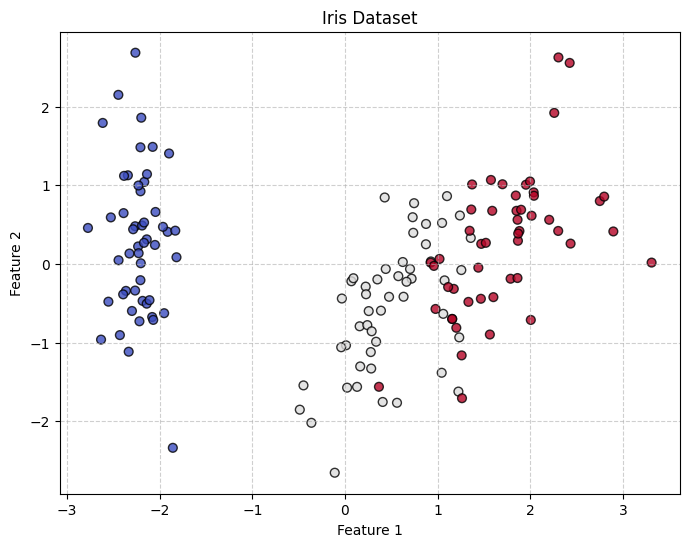

In [191]:
iris = load_iris()

# Guardamos en un Dataframe
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

# Separamos etiquetas
X, y = iris.data, iris.target

# Separamos en conjuntos de entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalamos los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Redimensionalización previo a graficar
pca = PCA(n_components=2)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))

# Visulizazión del Dataset
plt.figure(figsize=(10, 7)) # You can set the figure size beforehand
plot_data_distribution(X_pca, y, title="Iris Dataset")
plt.show()

#### LinearSVC

Accuracy: 0.9
Precision: 0.9023569023569025
Recall: 0.9
F1-Score: 0.8997493734335839


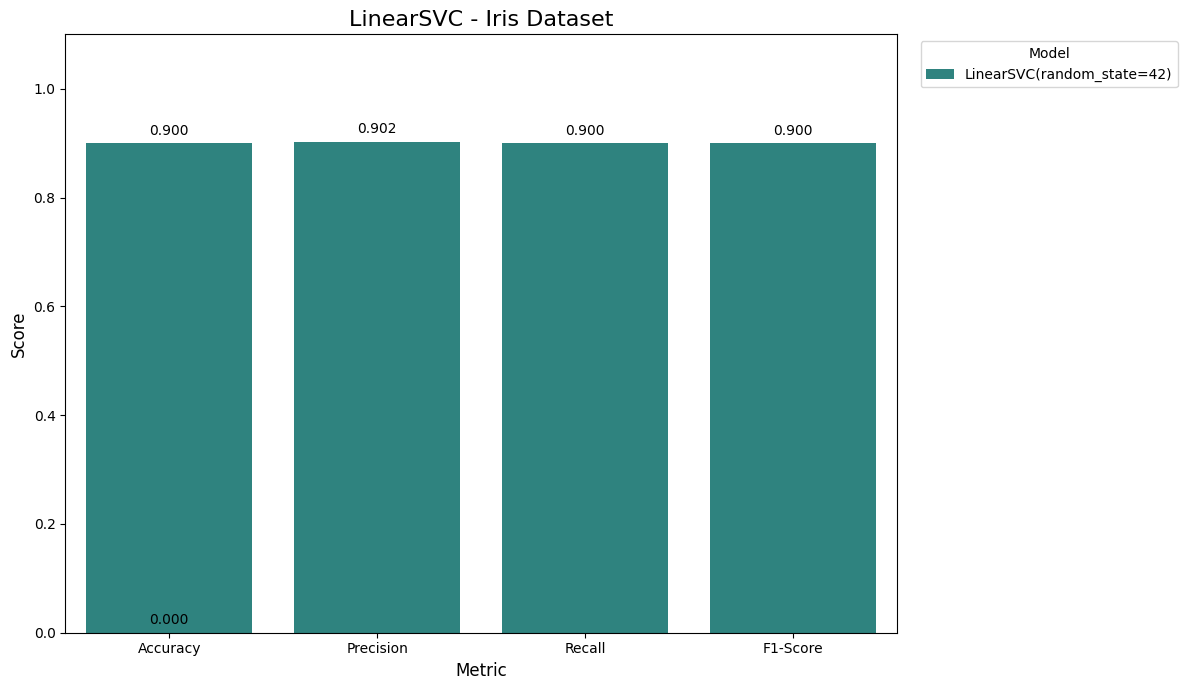

In [192]:
# Crear el modelo
model = LinearSVC(random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Predicciones con el conjunto de pruebas
y_pred = model.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Accuracy
print(f"Accuracy: {accuracy}")

# Precision
print(f"Precision: {precision}")

# Recall
print(f"Recall: {recall}")

# F1-Score
print(f"F1-Score: {f1}")

# Guardamos en diccionario
metrics_data = {}

metrics_data[model] = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

# Guardamos en un Dataframe
df_metrics = pd.DataFrame.from_dict(metrics_data, orient='index')

# Graficamos las métricas
plot_model_metrics(df_metrics, title='LinearSVC - Iris Dataset')

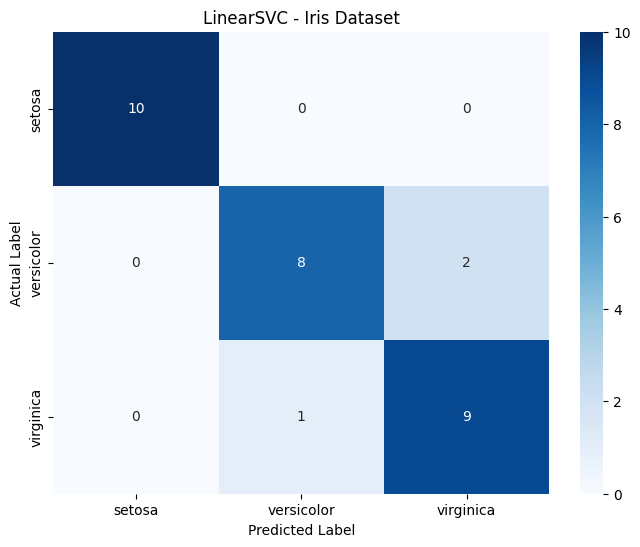

In [193]:
plot_confusion_matrix(y_test, y_pred, class_names=iris.target_names, title='LinearSVC - Iris Dataset')

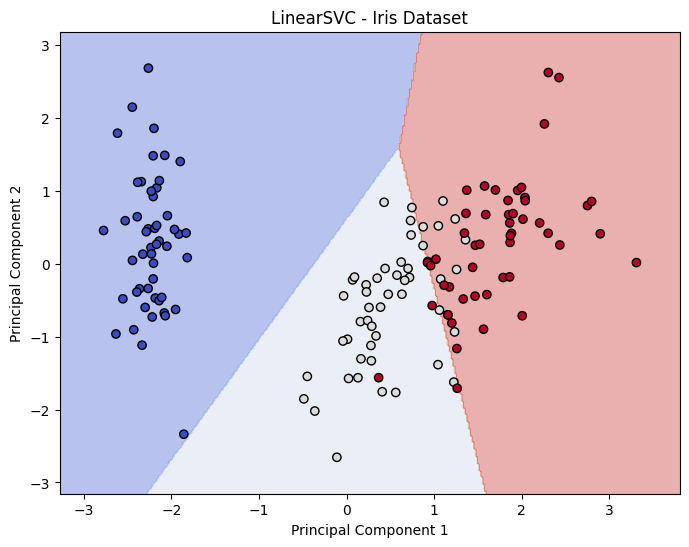

In [194]:
# Reducimos a dos características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
ax = plt.gca()
plot_decision_boundary(model, X_2d, y, ax=ax, title="LinearSVC - Iris Dataset")
plt.show()

#### MLP

Accuracy: 0.9666666666666667
Precision: 0.9696969696969696
Recall: 0.9666666666666667
F1-Score: 0.9665831244778613


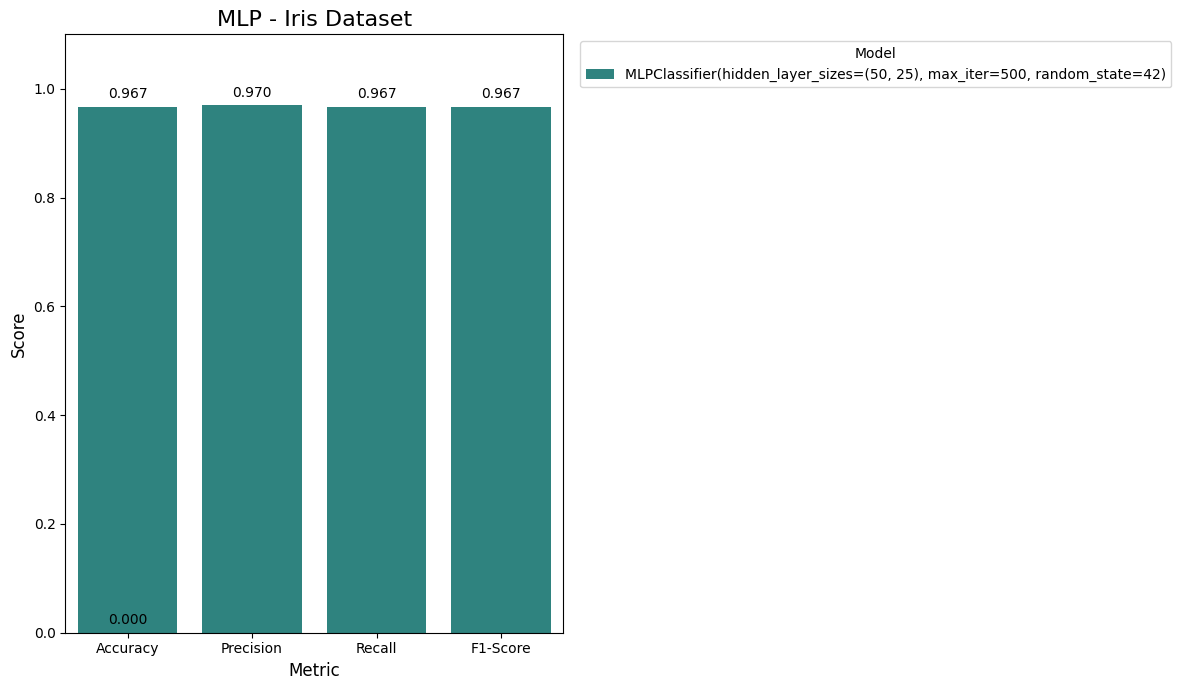

In [148]:
# Crear el modelo
model = MLPClassifier(hidden_layer_sizes=(50, 25), 
                          max_iter=500, activation='relu', random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Predicciones con el conjunto de pruebas
y_pred = model.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Accuracy
print(f"Accuracy: {accuracy}")

# Precision
print(f"Precision: {precision}")

# Recall
print(f"Recall: {recall}")

# F1-Score
print(f"F1-Score: {f1}")

# Guardamos en diccionario
metrics_data = {}

metrics_data[model] = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

# Guardamos en un Dataframe
df_metrics = pd.DataFrame.from_dict(metrics_data, orient='index')

# Graficamos las métricas
plot_model_metrics(df_metrics, title='MLP - Iris Dataset')

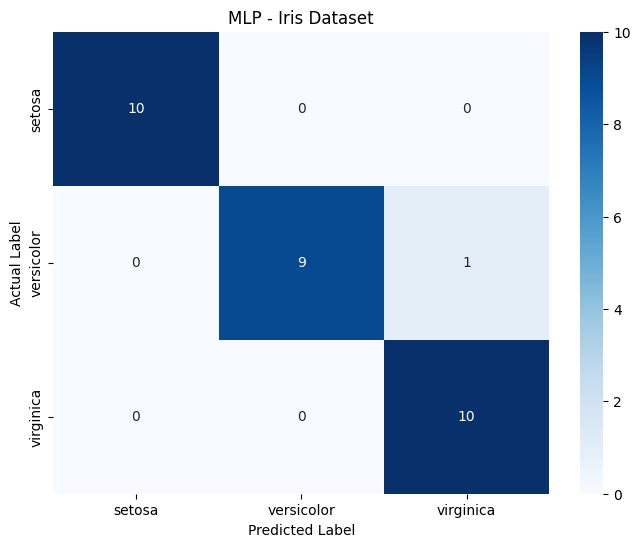

In [150]:
plot_confusion_matrix(y_test, y_pred, class_names=iris.target_names, title='MLP - Iris Dataset')

C:\Users\lopez\anaconda3\envs\machineLearning\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


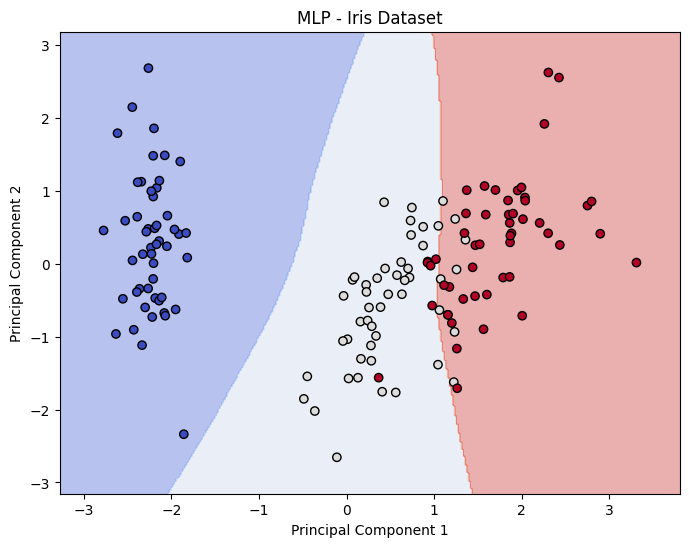

In [151]:
# Reducimos a dos características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
ax = plt.gca()
plot_decision_boundary(model, X_2d, y, ax=ax, title="MLP - Iris Dataset")
plt.show()

### Digits Dataset

<Figure size 1000x700 with 0 Axes>

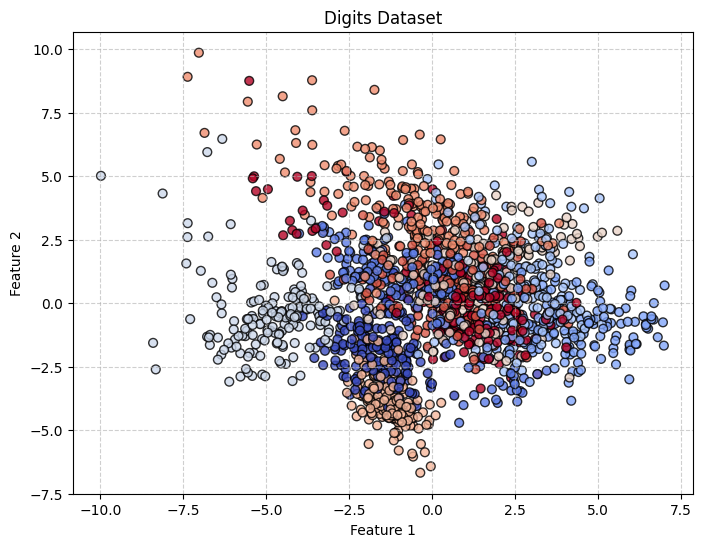

In [155]:
digits = load_digits()

# Guardamos en un Dataframe
df = pd.DataFrame(data=digits.data, columns=digits.feature_names)

# Separamos etiquetasAC
X, y = digits.data, digits.target

# Separamos en conjuntos de entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalamos los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Redimensionalización previo a graficar
pca = PCA(n_components=2)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))

# Visulizazión del Dataset
plt.figure(figsize=(10, 7)) # You can set the figure size beforehand
plot_data_distribution(X_pca, y, title="Digits Dataset")
plt.show()

#### AdaBoost

Accuracy: 0.9333333333333333
Precision: 0.9333333333333333
Recall: 0.9333333333333333
F1-Score: 0.9333333333333333


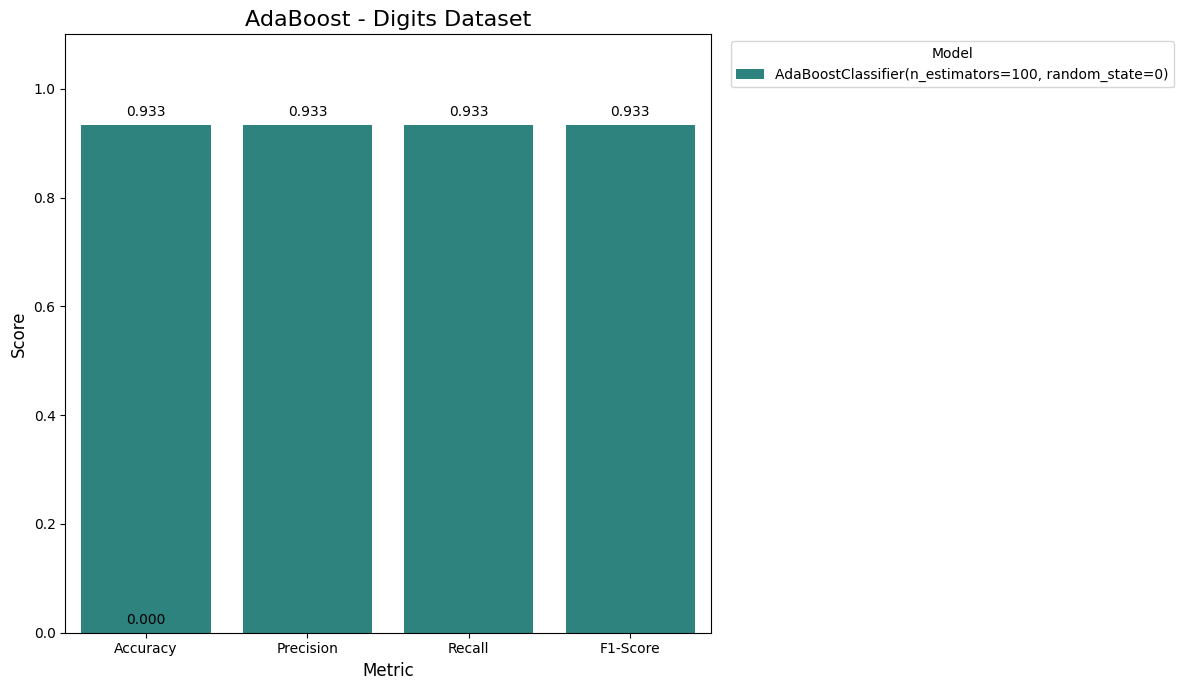

In [157]:
# Crear el modelo
model = AdaBoostClassifier(n_estimators=100, random_state=0)

# Entrenar el modelo
model.fit(X_train, y_train)

# Predicciones con el conjunto de pruebas
y_pred = model.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Accuracy
print(f"Accuracy: {accuracy}")

# Precision
print(f"Precision: {precision}")

# Recall
print(f"Recall: {recall}")

# F1-Score
print(f"F1-Score: {f1}")

# Guardamos en diccionario
metrics_data = {}

metrics_data[model] = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

# Guardamos en un Dataframe
df_metrics = pd.DataFrame.from_dict(metrics_data, orient='index')

# Graficamos las métricas
plot_model_metrics(df_metrics, title='AdaBoost - Digits Dataset')

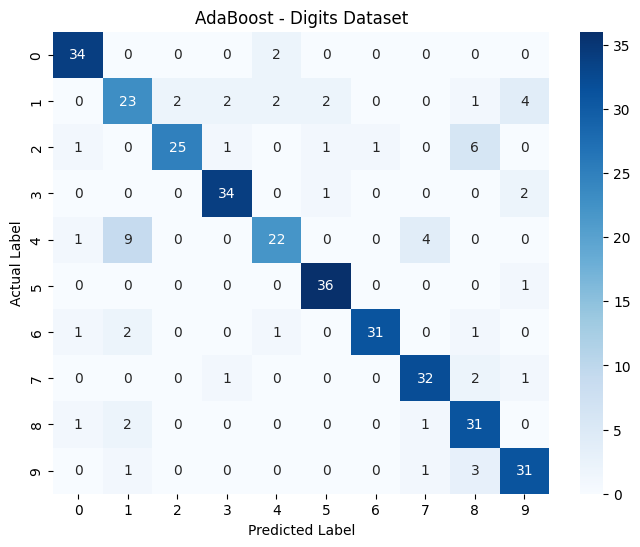

In [93]:
plot_confusion_matrix(y_test, y_pred, class_names=digits.target_names, title='AdaBoost - Digits Dataset')

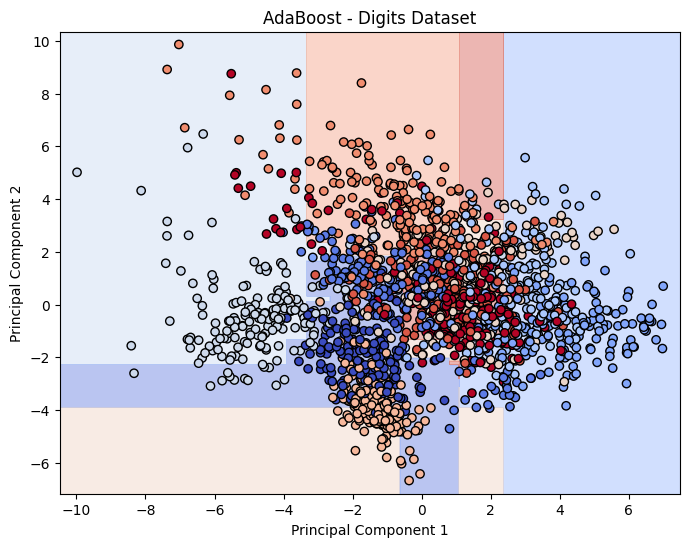

In [94]:
# Reducimos a dos características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
ax = plt.gca()
plot_decision_boundary(model, X_2d, y, ax=ax, title="AdaBoost - Digits Dataset")
plt.show()

### Breast Cancer Wisconsin Dataset

<Figure size 1000x700 with 0 Axes>

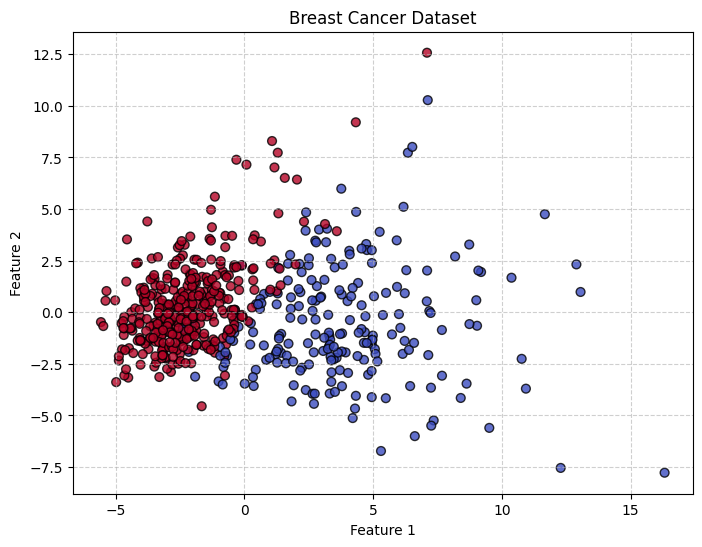

In [174]:
cancer = load_breast_cancer()

# Guardamos en un Dataframe
df = pd.DataFrame(data=cancer.data, columns=cancer.feature_names)

# Separamos etiquetas
X, y = cancer.data, cancer.target

# Separamos en conjuntos de entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalamos los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Redimensionalización previo a graficar
pca = PCA(n_components=2)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))

# Visulizazión del Dataset
plt.figure(figsize=(10, 7)) # You can set the figure size beforehand
plot_data_distribution(X_pca, y, title="Breast Cancer Dataset")
plt.show()

#### NuSVC

Accuracy: 0.9385964912280702
Precision: 0.9390013495276655
Recall: 0.9385964912280702
F1-Score: 0.9380859556298152


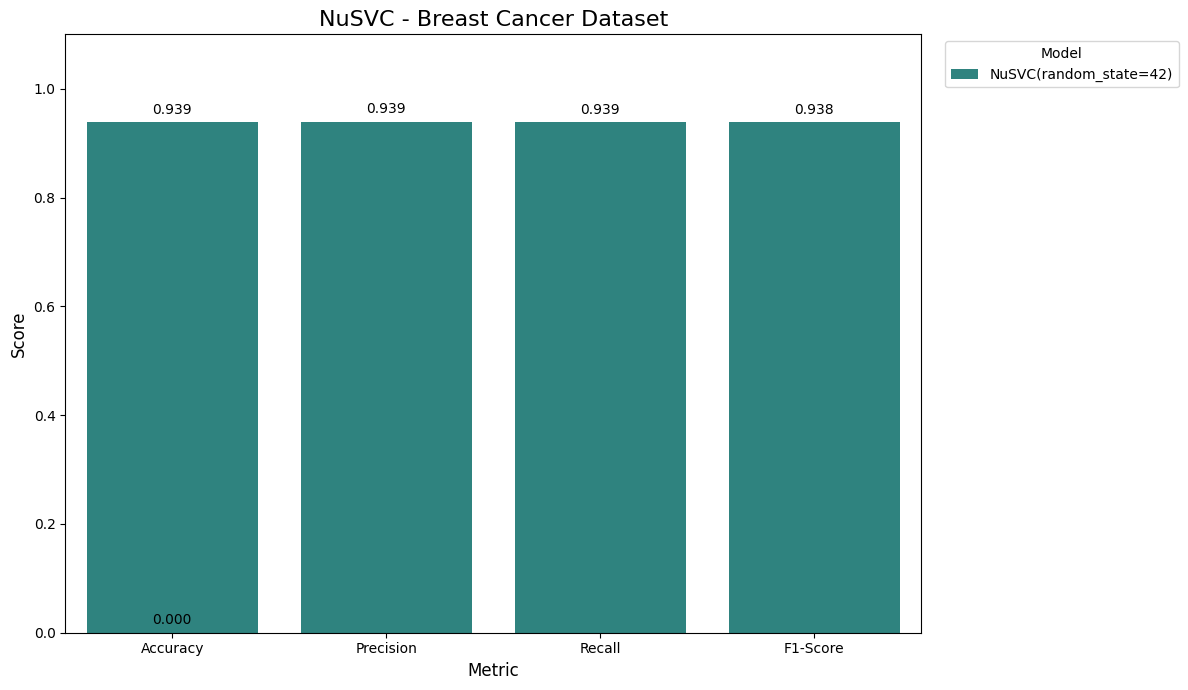

In [175]:
# Crear el modelo
model = NuSVC(random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Predicciones con el conjunto de pruebas
y_pred = model.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Accuracy
print(f"Accuracy: {accuracy}")

# Precision
print(f"Precision: {precision}")

# Recall
print(f"Recall: {recall}")

# F1-Score
print(f"F1-Score: {f1}")

# Guardamos en diccionario
metrics_data = {}

metrics_data[model] = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

# Guardamos en un Dataframe
df_metrics = pd.DataFrame.from_dict(metrics_data, orient='index')

# Graficamos las métricas
plot_model_metrics(df_metrics, title='NuSVC - Breast Cancer Dataset')

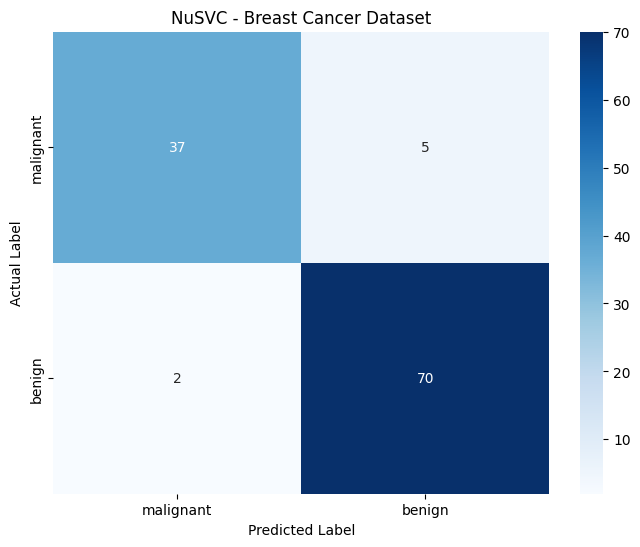

In [97]:
plot_confusion_matrix(y_test, y_pred, class_names=cancer.target_names, title='NuSVC - Breast Cancer Dataset')

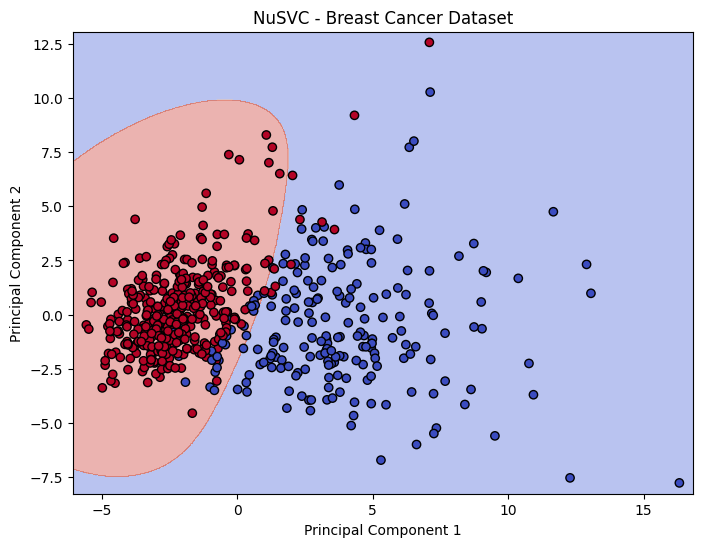

In [98]:
# Reducimos a dos características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
ax = plt.gca()
plot_decision_boundary(model, X_2d, y, ax=ax, title="NuSVC - Breast Cancer Dataset")
plt.show()

### Titanic ML Dataset

<Figure size 1000x700 with 0 Axes>

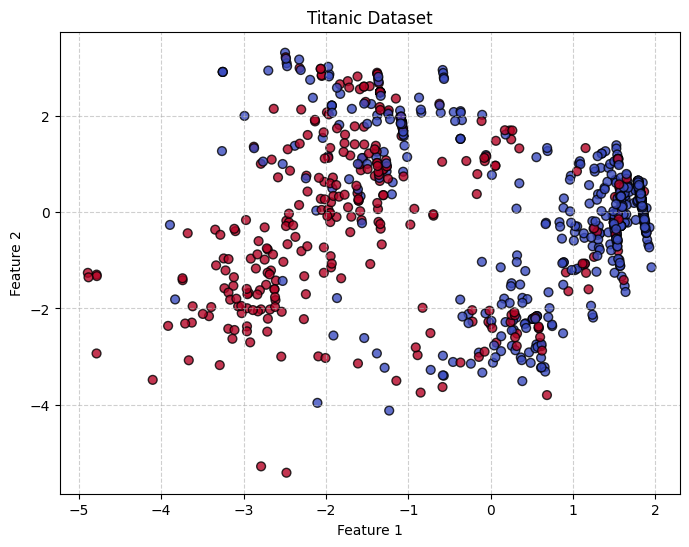

In [176]:
# Guardamos en un Dataframe
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "yasserh/titanic-dataset",
  "Titanic-Dataset.csv",
)

# Visualización del Dataset
# print(df)

# Eliminamos ID y Ticket, no aportan nada en la predicción
df.drop(columns=["PassengerId", "Ticket"], inplace=True)

# Checamos si hay datos nulos
# df.isnull().sum()

# Llenamos Embarked con el valor más repetido (moda)
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

# Llenamos Age con la mediana de edades
df["Age"] = df["Age"].fillna(df["Age"].median())

# Nueva columna que reemplaza a Cabin con Has_Cabin
df["Has_Cabin"] = df["Cabin"].notnull().astype(int)
df.drop(columns=["Cabin"], inplace=True)

# Nueva columna que reemplaza a Name con Title
df["Title"] = df["Name"].apply(lambda x: x.split(", ")[1].split(".")[0].strip())
df.drop(columns=["Name"], inplace=True)
df["Title"] = df["Title"].replace(['Lady', 'the Countess','Capt','Col','Don','Dr',
                                   'Major','Rev','Sir','Jonkheer','Dona'], 'Rare')
df["Title"] = df["Title"].replace('Mlle', 'Miss')
df["Title"] = df["Title"].replace('Ms', 'Miss')
df["Title"] = df["Title"].replace('Mme', 'Mrs')

# Aplicamos Encode manual a la columna Sex
sex_map = {"male": 1, "female": 0}
df["Sex"] = df["Sex"].map(sex_map)

# Aplicamos One-Hot Encoding a las columnas Title y Embarked
df = pd.get_dummies(df, columns=['Title', 'Embarked'], drop_first=True)

# Dataset limpio
# print(df)

# Separamos etiquetas
X = df.drop('Survived', axis=1)
y = df['Survived']

# Separamos en conjuntos de entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalamos los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Redimensionalización previo a graficar
pca = PCA(n_components=2)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))

# Visulizazión del Dataset
plt.figure(figsize=(10, 7)) # You can set the figure size beforehand
plot_data_distribution(X_pca, y, title="Titanic Dataset")
plt.show()

#### KNN

Accuracy: 0.8212290502793296
Precision: 0.8199443602560332
Recall: 0.8212290502793296
F1-Score: 0.8201569963431048


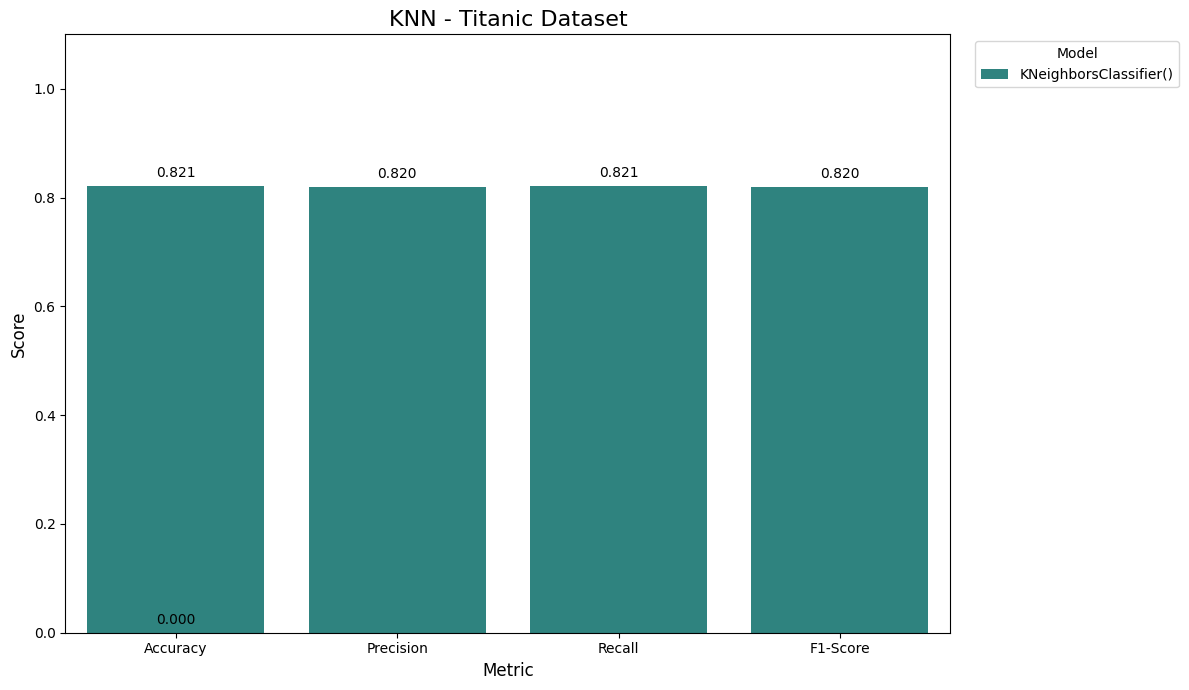

In [177]:
# Crear el modelo
model = KNeighborsClassifier(n_neighbors=5)

# Entrenar el modelo
model.fit(X_train, y_train)

# Predicciones con el conjunto de pruebas
y_pred = model.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Accuracy
print(f"Accuracy: {accuracy}")

# Precision
print(f"Precision: {precision}")

# Recall
print(f"Recall: {recall}")

# F1-Score
print(f"F1-Score: {f1}")

# Guardamos en diccionario
metrics_data = {}

metrics_data[model] = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

# Guardamos en un Dataframe
df_metrics = pd.DataFrame.from_dict(metrics_data, orient='index')

# Graficamos las métricas
plot_model_metrics(df_metrics, title='KNN - Titanic Dataset')

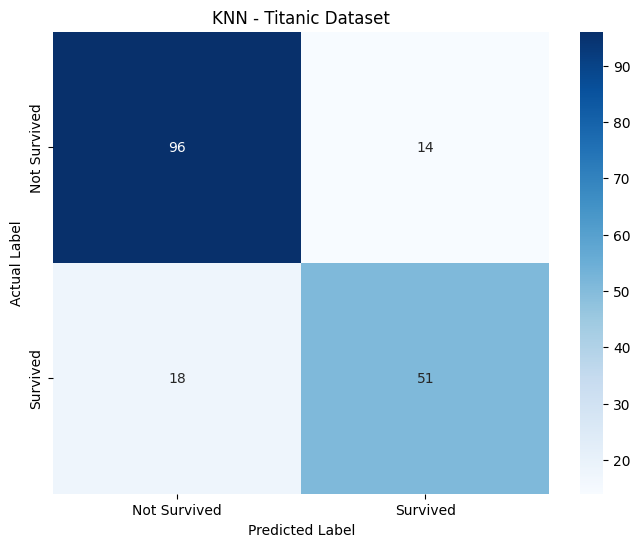

In [103]:
plot_confusion_matrix(y_test, y_pred, class_names=["Not Survived", "Survived"], title='KNN - Titanic Dataset')

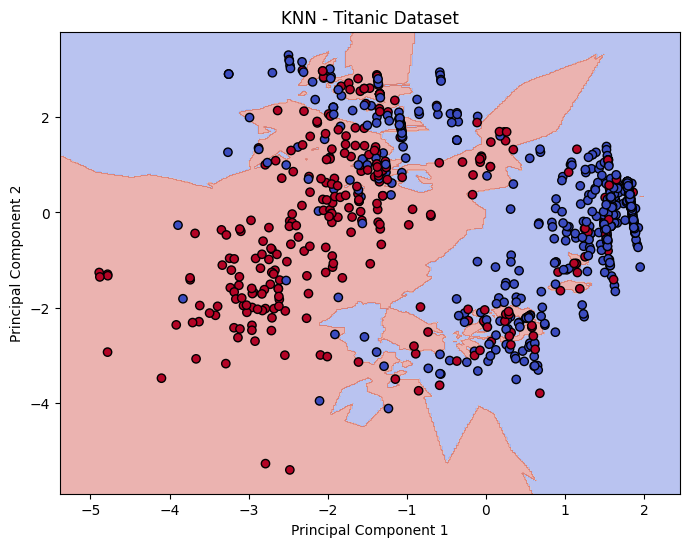

In [104]:
# Reducimos a dos características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
ax = plt.gca()
plot_decision_boundary(model, X_2d, y, ax=ax, title="KNN - Titanic Dataset")
plt.show()

#### GradientBoost

Accuracy: 0.7932960893854749
Precision: 0.7919455093776545
Recall: 0.7932960893854749
F1-Score: 0.7923897643165123


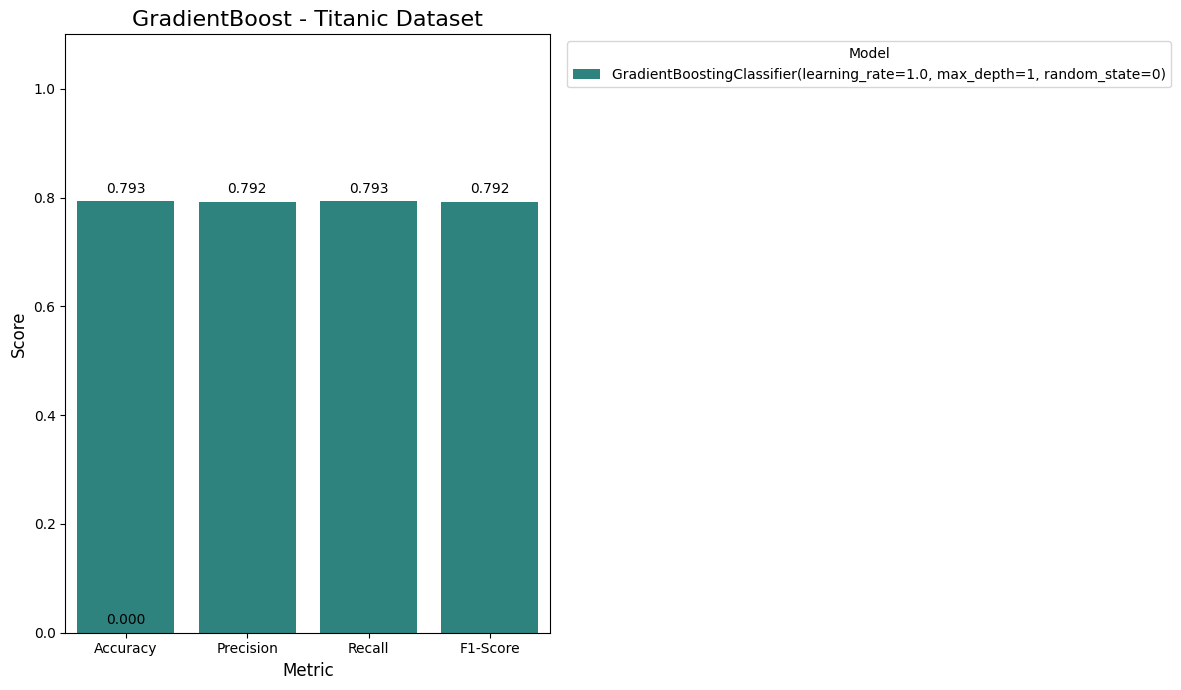

In [178]:
# Crear el modelo
model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)

# Entrenar el modelo
model.fit(X_train, y_train)

# Predicciones con el conjunto de pruebas
y_pred = model.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Accuracy
print(f"Accuracy: {accuracy}")

# Precision
print(f"Precision: {precision}")

# Recall
print(f"Recall: {recall}")

# F1-Score
print(f"F1-Score: {f1}")

# Guardamos en diccionario
metrics_data = {}

metrics_data[model] = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

# Guardamos en un Dataframe
df_metrics = pd.DataFrame.from_dict(metrics_data, orient='index')

# Graficamos las métricas
plot_model_metrics(df_metrics, title='GradientBoost - Titanic Dataset')

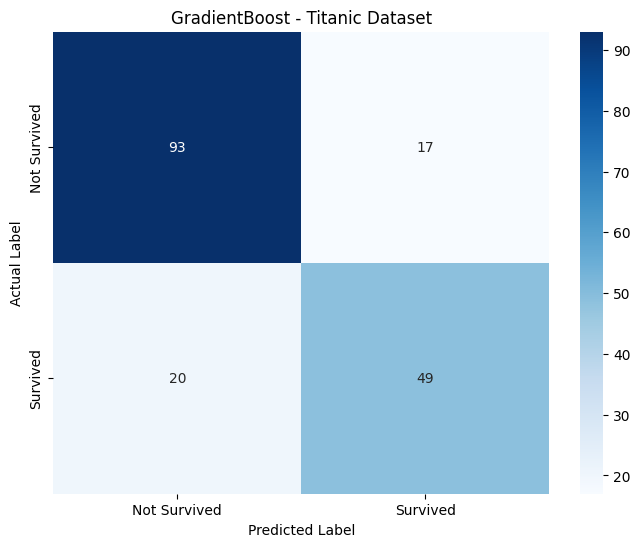

In [106]:
plot_confusion_matrix(y_test, y_pred, class_names=["Not Survived", "Survived"], title='GradientBoost - Titanic Dataset')

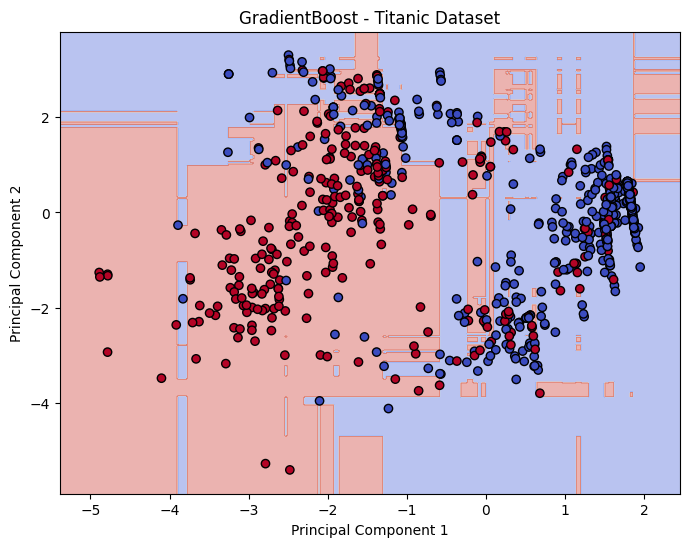

In [107]:
# Reducimos a dos características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
ax = plt.gca()
plot_decision_boundary(model, X_2d, y, ax=ax, title="GradientBoost - Titanic Dataset")
plt.show()

### MNIST Handwritten Digits Dataset

<Figure size 1000x700 with 0 Axes>

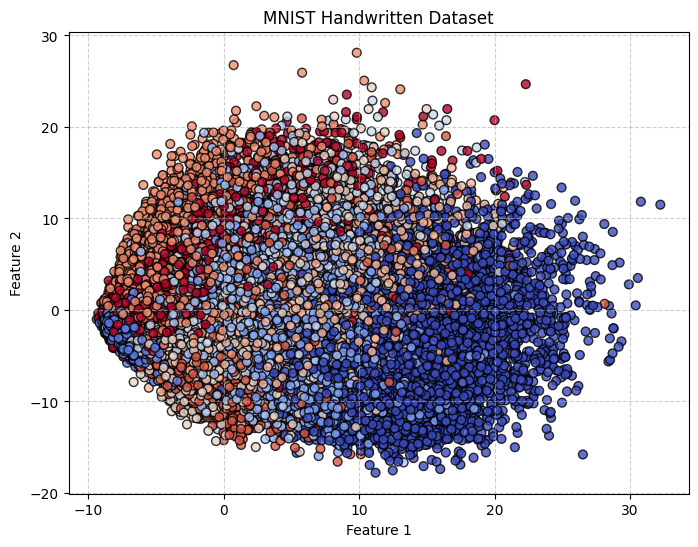

In [180]:
# Importamos el Dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Redimensionamos los datos para que DecisionTree los acepte
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

# Redimensionalización previo a graficar
pca = PCA(n_components=2)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X_train))

# Visulizazión del Dataset
plt.figure(figsize=(10, 7)) # You can set the figure size beforehand
plot_data_distribution(X_pca, y_train, title="MNIST Handwritten Dataset")
plt.show()

#### DecisionTree

Accuracy: 0.8813
Precision: 0.8810354798739223
Recall: 0.8813
F1-Score: 0.8810517484718479


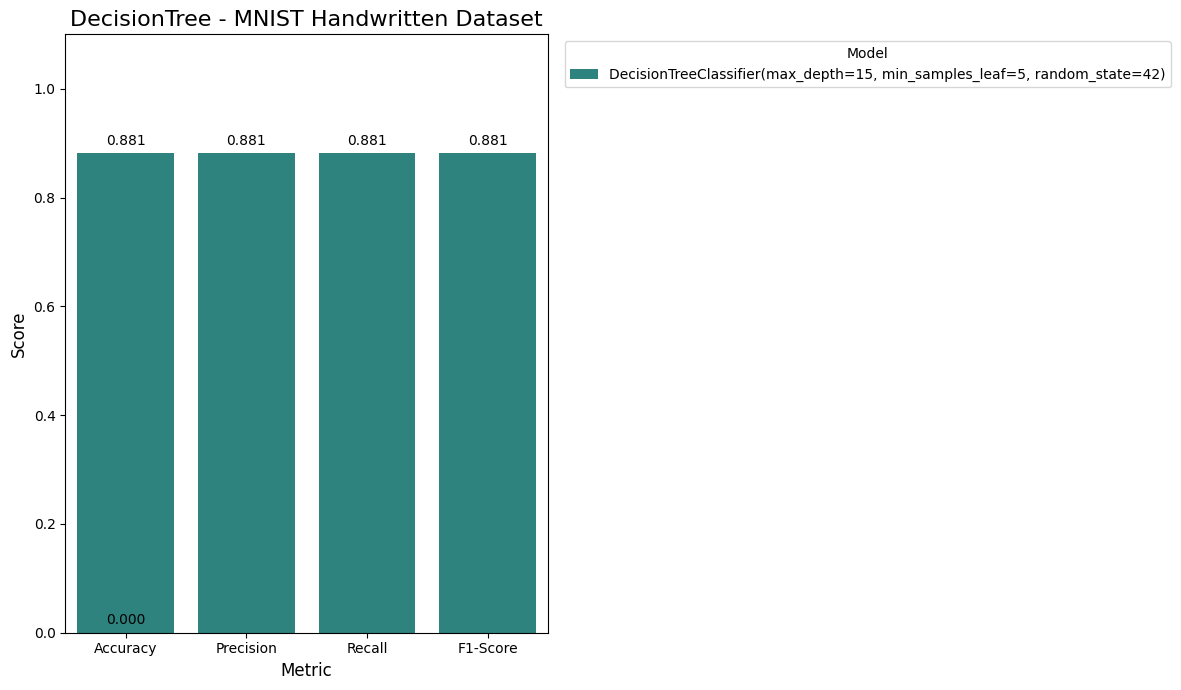

In [181]:
# Crear el modelo
model = DecisionTreeClassifier(max_depth=15, min_samples_leaf=5, 
                               random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Predicciones con el conjunto de pruebas
y_pred = model.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Accuracy
print(f"Accuracy: {accuracy}")

# Precision
print(f"Precision: {precision}")

# Recall
print(f"Recall: {recall}")

# F1-Score
print(f"F1-Score: {f1}")

# Guardamos en diccionario
metrics_data = {}

metrics_data[model] = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

# Guardamos en un Dataframe
df_metrics = pd.DataFrame.from_dict(metrics_data, orient='index')

# Graficamos las métricas
plot_model_metrics(df_metrics, title='DecisionTree - MNIST Handwritten Dataset')

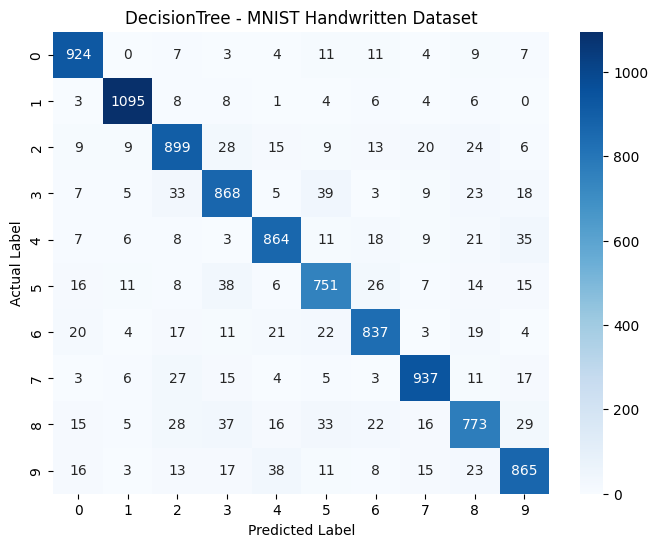

In [168]:
plot_confusion_matrix(y_test, y_pred, class_names=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], title='DecisionTree - MNIST Handwritten Dataset')

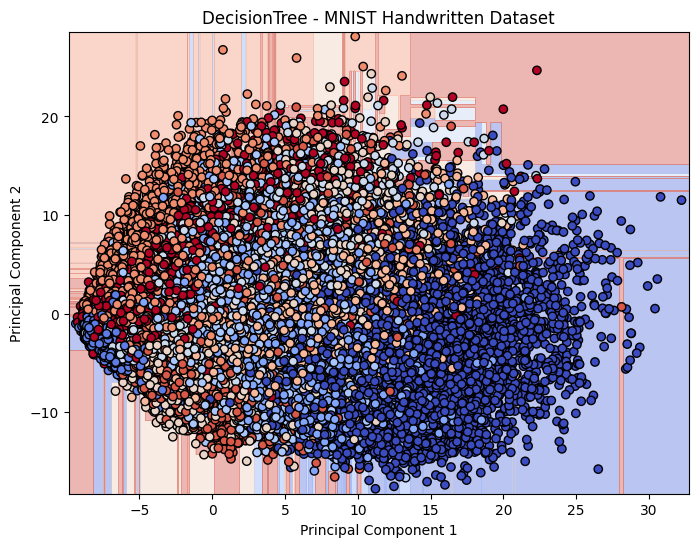

In [169]:
# Reducimos a dos características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
ax = plt.gca()
plot_decision_boundary(model, X_2d, y_train, ax=ax, title="DecisionTree - MNIST Handwritten Dataset")
plt.show()

### Spam Vs. Ham Email Dataset

In [200]:
# Importar Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
urllib.request.urlretrieve(url, "smsspamcollection.zip")

# Leemos el Dataset
with zipfile.ZipFile("smsspamcollection.zip") as z:
    with z.open("SMSSpamCollection") as f:
        df = pd.read_csv(f, sep="\t", names=["label", "message"])

# Imprimimos el Dataset
print(df)

# Mapeamos las etiquetas
df["label"] = df["label"].map({"spam": 1, "ham": 0})

# Usamos PorterStemmer para reducir las palabras a su raíz morfológica
ps = PorterStemmer()
stopwords_set = set(stopwords.words('english')) 

# Función para limpiar el texto
def clean_text(text):
    # Quitamos lo que no sean letras
    review = re.sub('[^a-zA-Z]', ' ', text)
    review = review.lower()
    review = review.split()
    
    # Quitamos las 'stopwords' y aplicamos el stemming
    review = [ps.stem(word) for word in review if word not in stopwords_set]
    review = ' '.join(review)
    return review

# Guardamos en nuestro Dataframe original
df["message"] = df["message"].apply(clean_text)

# Imprimimos el dataset limpio
print(df)

     label                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham               Will ü b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]
      label                                            message
0         0  go jurong point crazi avail bugi n great world...
1         0                              ok lar joke wif u oni
2         1  free entri wkli comp win fa c

<Figure size 1000x700 with 0 Axes>

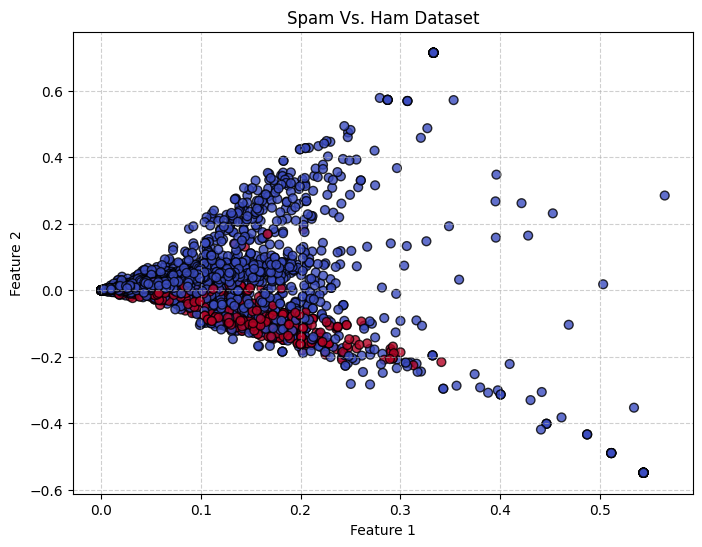

In [201]:
# Vectorizamos los datos
X = df['message']
y = df['label']
tfidf_vectorizer = TfidfVectorizer(max_features=3000)
X = tfidf_vectorizer.fit_transform(X)

# Redimensionalización previo a graficar
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X)

# Visulizazión del Dataset
plt.figure(figsize=(10, 7)) # You can set the figure size beforehand
plot_data_distribution(X_svd, y, title="Spam Vs. Ham Dataset")
plt.show()

In [202]:
# Separamos en conjuntos de entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### SVC

Accuracy: 0.979372197309417
Precision: 0.9796448633241104
Recall: 0.979372197309417
F1-Score: 0.9787011791558241


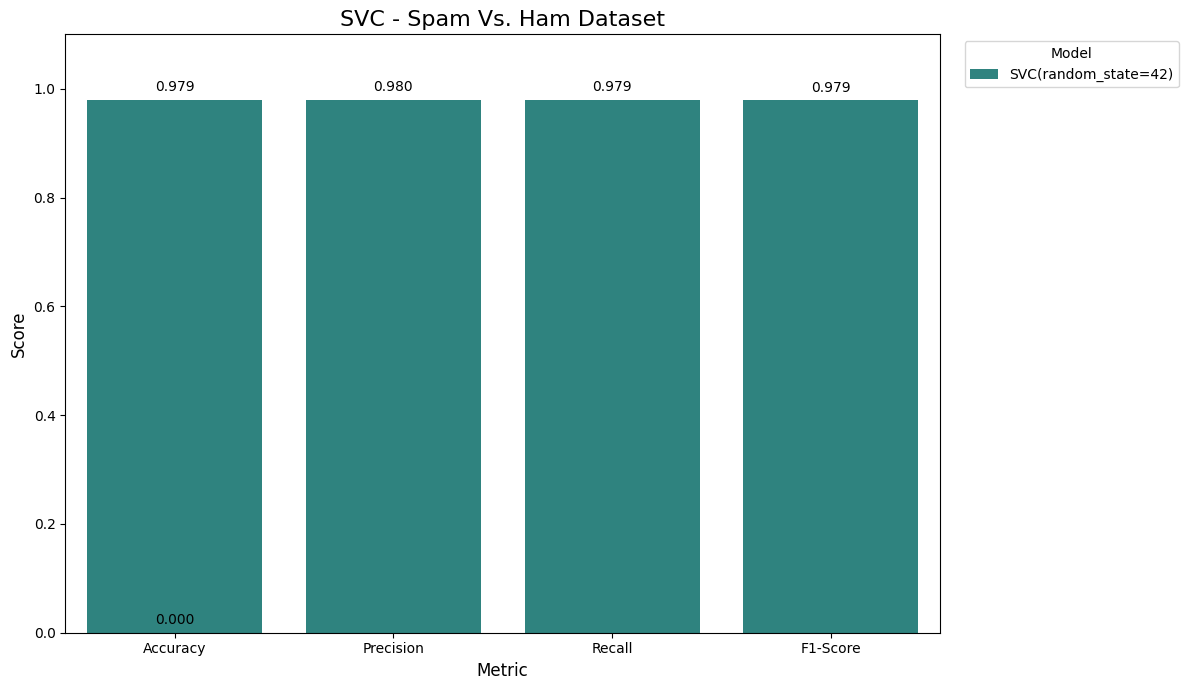

In [206]:
# Crear el modelo
model = SVC(random_state=42)

# Entrenar el modelo
model.fit(X_train[:20000], y_train[:20000])

# Predicciones con el conjunto de pruebas
y_pred = model.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Accuracy
print(f"Accuracy: {accuracy}")

# Precision
print(f"Precision: {precision}")

# Recall
print(f"Recall: {recall}")

# F1-Score
print(f"F1-Score: {f1}")

# Guardamos en diccionario
metrics_data = {}

metrics_data[model] = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

# Guardamos en un Dataframe
df_metrics = pd.DataFrame.from_dict(metrics_data, orient='index')

# Graficamos las métricas
plot_model_metrics(df_metrics, title='SVC - Spam Vs. Ham Dataset')

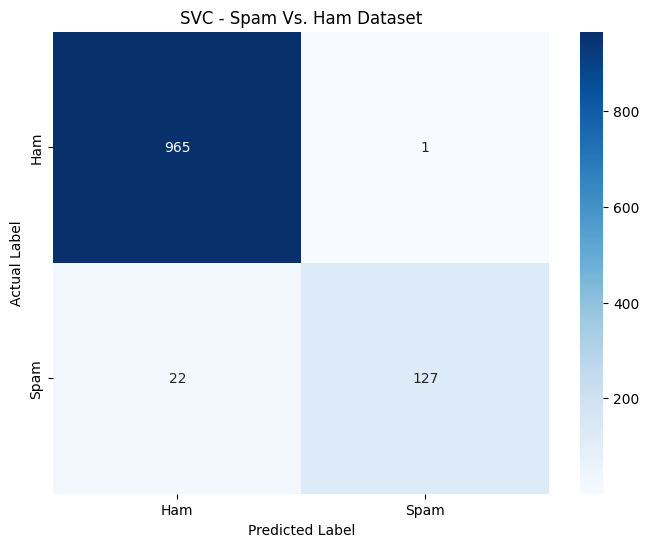

In [207]:
plot_confusion_matrix(y_test, y_pred, class_names=["Ham", "Spam"], title='SVC - Spam Vs. Ham Dataset')

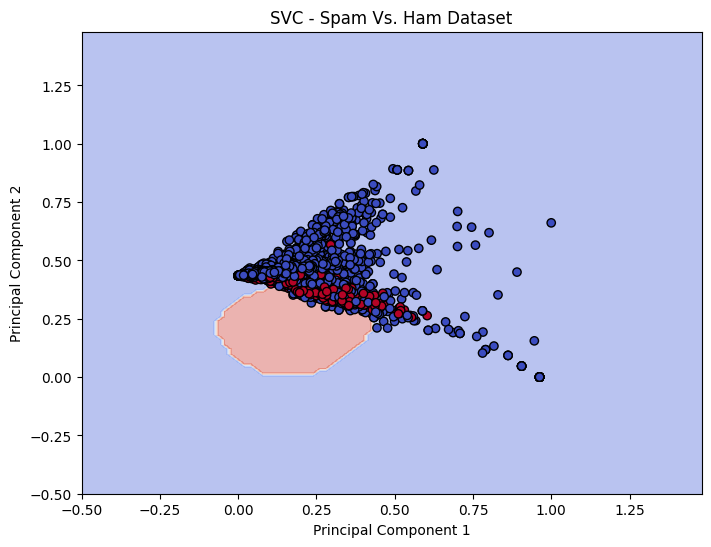

In [208]:
# Reducimos a dos características
svd = TruncatedSVD(n_components=2)
X_2d = svd.fit_transform(X)

scaler_2d = MinMaxScaler()
X_2d_scaled = scaler_2d.fit_transform(X_2d)

plt.figure(figsize=(8, 6))
ax = plt.gca()
plot_decision_boundary(model, X_2d_scaled, y, ax=ax, title="SVC - Spam Vs. Ham Dataset")
plt.show()

#### NaiveBayes

Accuracy: 0.9775784753363229
Precision: 0.9779153361904431
Recall: 0.9775784753363229
F1-Score: 0.9767727392628474


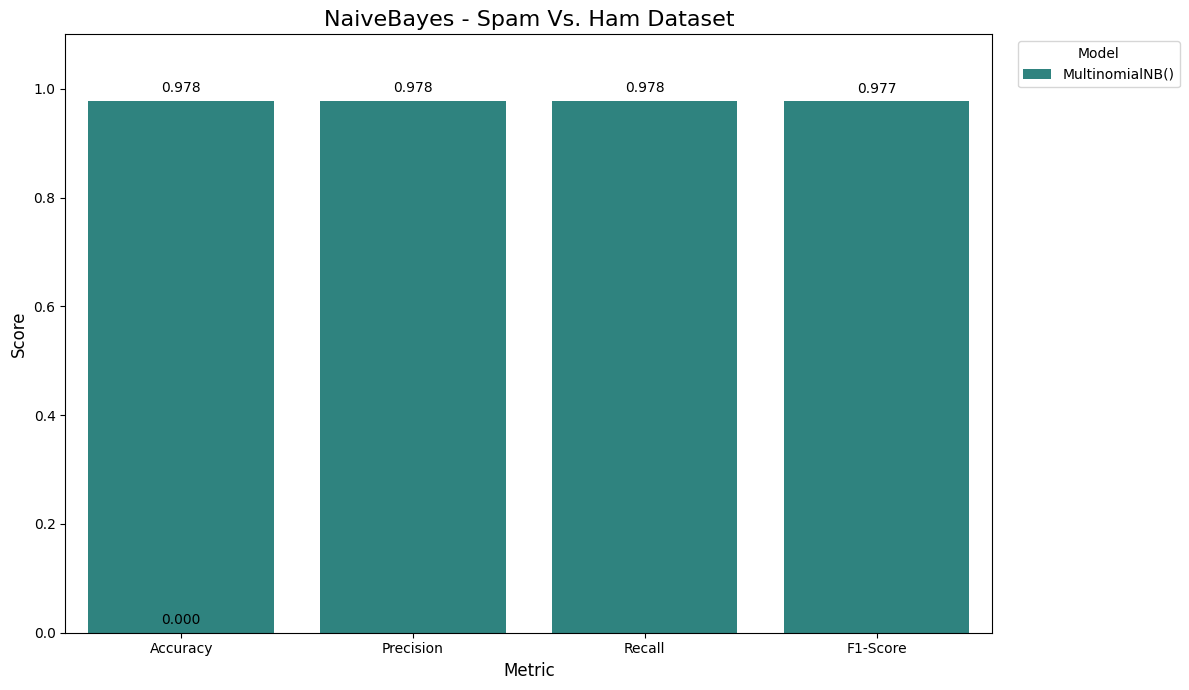

In [209]:
# Crear el modelo
model = MultinomialNB()

# Entrenar el modelo
model.fit(X_train, y_train)

# Predicciones con el conjunto de pruebas
y_pred = model.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Accuracy
print(f"Accuracy: {accuracy}")

# Precision
print(f"Precision: {precision}")

# Recall
print(f"Recall: {recall}")

# F1-Score
print(f"F1-Score: {f1}")

# Guardamos en diccionario
metrics_data = {}

metrics_data[model] = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

# Guardamos en un Dataframe
df_metrics = pd.DataFrame.from_dict(metrics_data, orient='index')

# Graficamos las métricas
plot_model_metrics(df_metrics, title='NaiveBayes - Spam Vs. Ham Dataset')

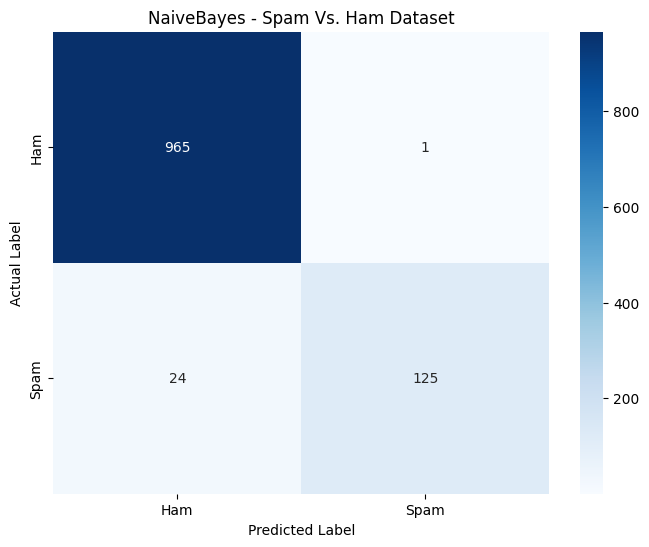

In [204]:
plot_confusion_matrix(y_test, y_pred, class_names=["Ham", "Spam"], title='NaiveBayes - Spam Vs. Ham Dataset')

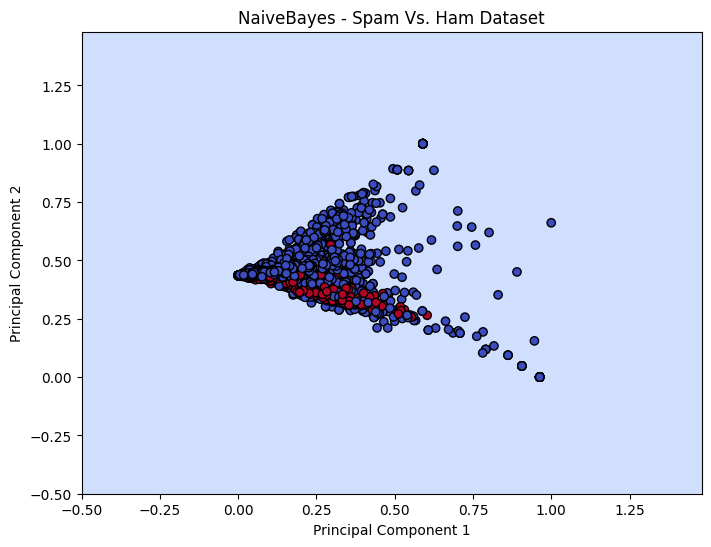

In [205]:
# Reducimos a dos características
svd = TruncatedSVD(n_components=2)
X_2d = svd.fit_transform(X)

scaler_2d = MinMaxScaler()
X_2d_scaled = scaler_2d.fit_transform(X_2d)

plt.figure(figsize=(8, 6))
ax = plt.gca()
plot_decision_boundary(model, X_2d_scaled, y, ax=ax, title="NaiveBayes - Spam Vs. Ham Dataset")
plt.show()